# Settings

## Constant

In [1]:
import pytz
import os


DEFAULT_TZ = pytz.FixedOffset(540)  # GMT+09:00; Asia/Seoul

PATH_DATA = './data'
PATH_ESM = os.path.join(PATH_DATA, 'EsmResponse.csv')
PATH_PARTICIPANT = os.path.join(PATH_DATA, 'UserInfo.csv')
PATH_SENSOR = os.path.join(PATH_DATA, 'Sensor')

PATH_INTERMEDIATE = './intermediate'

DATA_TYPES = {
    'EDA': 'EDA',
    'HR': 'HRT',
    'RRI': 'RRI',
    'SkinTemperature': 'SKT',
}


## Utility Functions

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import cloudpickle
import ray
from datetime import datetime
from contextlib import contextmanager
import warnings
import time


def load(path: str):
    with open(path, mode='rb') as f:
        return cloudpickle.load(f)
    
def dump(obj, path: str):
    with open(path, mode='wb') as f:
        cloudpickle.dump(obj, f)
    
def log(msg: any):
    print('[{}] {}'.format(datetime.now().strftime('%y-%m-%d %H:%M:%S'), msg))

def summary(x):
    x = np.asarray(x)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')

        n = len(x)
        # Here, uppercase np.dtype.kind corresponds to non-numeric data.
        # Also, we view the boolean data as dichotomous categorical data.
        if x.dtype.kind.isupper() or x.dtype.kind == 'b': 
            cnt = pd.Series(x).value_counts(dropna=False)
            card = len(cnt)
            cnt = cnt[:20]                
            cnt_str = ', '.join([f'{u}:{c}' for u, c in zip(cnt.index, cnt)])
            if card > 30:
                cnt_str = f'{cnt_str}, ...'
            return {
                'n': n,
                'cardinality': card,
                'value_count': cnt_str
            }
        else: 
            x_nan = x[np.isnan(x)]
            x_norm = x[~np.isnan(x)]
            
            tot = np.sum(x_norm)
            m = np.mean(x_norm)
            me = np.median(x_norm)
            s = np.std(x_norm, ddof=1)
            l, u = np.min(x_norm), np.max(x)
            conf_l, conf_u = st.t.interval(0.95, len(x_norm) - 1, loc=m, scale=st.sem(x_norm))
            n_nan = len(x_nan)
            
            return {
                'n': n,
                'sum': tot,
                'mean': m,
                'SD': s,
                'med': me,
                'range': (l, u),
                'conf.': (conf_l, conf_u),
                'nan_count': n_nan
            }


@contextmanager
def on_ray(*args, **kwargs):
    try:
        if ray.is_initialized():
            ray.shutdown()
        ray.init(*args, **kwargs)
        yield None
    finally:
        ray.shutdown()

## Settings for R

In [3]:
# %load_ext rpy2.ipython

In [4]:
# %%R

# library(tidyverse)
# library(ggforce)
# library(ggpubr)
# library(showtext)
# library(rmcorr)
# library(patchwork)

# # font_add_google(
# #     name='Source Serif Pro',
# #     family='ssp',
# #     db_cache=FALSE
# # )

# showtext_auto()

# THEME_DEFAULT <- theme_bw(
#     base_size=10,
#     base_family='ssp',
# ) + theme(
#         axis.title.x=element_text(colour='grey20', size=10, face='bold'),
#         axis.title.y=element_text(colour='grey20', size=10, face='bold'),
#         axis.text.x=element_text(colour='grey20', size=10),
#         axis.text.y=element_text(colour='grey20', size=10),
#         strip.text.x=element_text(colour='grey20', size=10, face='bold'),
#         strip.text.y=element_text(colour='grey20', size=10, face='bold'),
#         legend.background=element_blank(),
#         legend.title=element_text(colour='grey20', size=10, face='bold'),
#         legend.text=element_text(colour='grey20', size=10),
#         legend.position='top',
#         legend.box.spacing= unit(0, 'cm'),
#         plot.subtitle=element_text(colour='grey20', size=10, hjust=.5),
#     )


# Dataset Overview

## Participants

In [5]:
import pandas as pd
import os


PARTICIPANTS = pd.read_csv(PATH_PARTICIPANT).set_index('pcode').assign(
    particpationStartDateTime=lambda x: pd.to_datetime(
        x['participationStartDate'], format='%Y-%m-%d'
    ).dt.tz_localize(DEFAULT_TZ)
)
PARTICIPANTS.head()

,participationStartDate,age,gender,openness,conscientiousness,neuroticism,extraversion,agreeableness,PSS,PHQ,GHQ,particpationStartDateTime
pcode,,,,,,,,,,,,
P01,2019-05-08,27,M,11,11,3,4,13,13,0,1,2019-05-08 00:00:00+09:00
P02,2019-05-08,21,M,14,5,12,14,5,27,6,18,2019-05-08 00:00:00+09:00
P03,2019-05-08,24,F,10,15,8,7,11,18,2,6,2019-05-08 00:00:00+09:00
P04,2019-05-08,23,M,12,11,8,6,11,20,1,9,2019-05-08 00:00:00+09:00
P05,2019-05-08,27,F,10,11,13,10,6,25,14,9,2019-05-08 00:00:00+09:00


Belows are some demographics:

In [6]:
for c in PARTICIPANTS.columns:
    print(f'- {c}:', summary(PARTICIPANTS[c]))

- participationStartDate: {'n': 77, 'cardinality': 3, 'value_count': '2019-05-08:27, 2019-05-16:25, 2019-04-30:25'}
- age: {'n': 77, 'sum': 1686, 'mean': 21.896103896103895, 'SD': 3.8613619617422406, 'med': 21.0, 'range': (17, 38), 'conf.': (21.01968223607122, 22.77252555613657), 'nan_count': 0}
- gender: {'n': 77, 'cardinality': 2, 'value_count': 'M:53, F:24'}
- openness: {'n': 77, 'sum': 787, 'mean': 10.220779220779221, 'SD': 2.8956563505732467, 'med': 11.0, 'range': (3, 15), 'conf.': (9.563545847995773, 10.87801259356267), 'nan_count': 0}
- conscientiousness: {'n': 77, 'sum': 820, 'mean': 10.64935064935065, 'SD': 2.3662441579221882, 'med': 11.0, 'range': (5, 15), 'conf.': (10.112279104782713, 11.186422193918586), 'nan_count': 0}
- neuroticism: {'n': 77, 'sum': 618, 'mean': 8.025974025974026, 'SD': 2.6900108881310953, 'med': 8.0, 'range': (3, 14), 'conf.': (7.4154164477308075, 8.636531604217245), 'nan_count': 0}
- extraversion: {'n': 77, 'sum': 703, 'mean': 9.12987012987013, 'SD': 3.

## Labels (via ESM)

In [7]:
import pandas as pd
import os


LABELS = pd.read_csv(PATH_ESM).set_index(
    ['pcode']
)
LABELS.head()

,responseTime,scheduledTime,valence,arousal,attention,stress,duration,disturbance,change
pcode,,,,,,,,,
P01,1557278103000,NaN,0,0,0,-1,20.0,3,-2
P01,1557278986000,1.557279e+12,-3,3,3,3,5.0,-1,-3
P01,1557281772000,1.557282e+12,-3,-2,2,2,15.0,3,-2
P01,1557287138000,NaN,2,-1,2,0,15.0,1,-1
P01,1557291117000,NaN,3,3,3,-3,20.0,1,0


In [8]:
for c in LABELS.columns:
    print(f'- {c}:', summary(LABELS[c]))

- responseTime: {'n': 5582, 'sum': 8694314195328000, 'mean': 1557562557385.8833, 'SD': 590915040.4254278, 'med': 1557562969500.0, 'range': (1556582982000, 1558545246000), 'conf.': (1557547052362.8618, 1557578062408.9048), 'nan_count': 0}
- scheduledTime: {'n': 5582, 'sum': 5175814282500000.0, 'mean': 1557572760306.9517, 'SD': 591697484.8543198, 'med': 1557565860000.0, 'range': (1556586120000.0, nan), 'conf.': (1557552635074.4736, 1557592885539.4297), 'nan_count': 2259}
- valence: {'n': 5582, 'sum': 3665, 'mean': 0.6565747044070226, 'SD': 1.4184297545899174, 'med': 1.0, 'range': (-3, 3), 'conf.': (0.6193565182132938, 0.6937928906007513), 'nan_count': 0}
- arousal: {'n': 5582, 'sum': -529, 'mean': -0.09476890003582945, 'SD': 1.6675313128774563, 'med': 0.0, 'range': (-3, 3), 'conf.': (-0.13852326339835566, -0.051014536673303246), 'nan_count': 0}
- attention: {'n': 5582, 'sum': 2236, 'mean': 0.4005732712289502, 'SD': 1.6113242733571864, 'med': 1.0, 'range': (-3, 3), 'conf.': (0.35829372468

Belows are some demographics:

In [9]:
inst = LABELS.groupby('pcode').count().iloc[:, -1]
inst_sch = LABELS.loc[lambda x: ~x['scheduledTime'].isna(), :].groupby('pcode').count().iloc[:, -1]
inst_vol = LABELS.loc[lambda x: x['scheduledTime'].isna(), :].groupby('pcode').count().iloc[:, -1]
resp_time = LABELS.assign(
    timestamp=lambda x: pd.to_datetime(x['responseTime'], unit='ms', utc=True).dt.tz_convert(DEFAULT_TZ)
)
sam = np.concatenate([
    (resp_time.loc[p, 'timestamp'].array - resp_time.loc[p, 'timestamp'].array.shift(1)).dropna().total_seconds()
    for p in LABELS.index.unique()
])

print('- # Inst.:', summary(inst))
print('- # Inst. - Scheduled:', summary(inst_sch))
print('- # Inst. - Voluntary:', summary(inst_vol))
print('- Samp. period:', summary(sam))
for c in LABELS.columns:
    print(f'- {c}:', summary(LABELS[c]))

- # Inst.: {'n': 77, 'sum': 5582, 'mean': 72.49350649350649, 'SD': 16.02270048911147, 'med': 74.0, 'range': (20, 110), 'conf.': (68.85679957506535, 76.13021341194762), 'nan_count': 0}
- # Inst. - Scheduled: {'n': 76, 'sum': 3323, 'mean': 43.723684210526315, 'SD': 19.36291898394835, 'med': 43.5, 'range': (3, 83), 'conf.': (39.29906768289902, 48.14830073815361), 'nan_count': 0}
- # Inst. - Voluntary: {'n': 77, 'sum': 2259, 'mean': 29.337662337662337, 'SD': 16.297893300742235, 'med': 27.0, 'range': (2, 74), 'conf.': (25.6384943127028, 33.03683036262187), 'nan_count': 0}
- Samp. period: {'n': 5505, 'sum': 42240670.0, 'mean': 7673.146230699364, 'SD': 13193.471538029606, 'med': 3090.0, 'range': (1.0, 136446.0), 'conf.': (7324.548923384188, 8021.743538014541), 'nan_count': 0}
- responseTime: {'n': 5582, 'sum': 8694314195328000, 'mean': 1557562557385.8833, 'SD': 590915040.4254278, 'med': 1557562969500.0, 'range': (1556582982000, 1558545246000), 'conf.': (1557547052362.8618, 1557578062408.9048)

### Plot

In [10]:
data = LABELS.loc[
    :, lambda x: ~x.columns.isin(['responseTime', 'scheduledTime'])
]

In [11]:
# %%R -i data -w 16 -h 6 -u cm

# data <- data %>% pivot_longer(
#     cols = c('valence', 'arousal', 'attention', 'stress', 'duration', 'disturbance', 'change'),
#     names_to = 'metric'
# )

# p_rest <- ggplot(
#     data %>% filter(metric != 'duration'), aes(x=metric, y=value)
# ) + geom_boxplot(
# ) + geom_point(
#     data = data %>% filter(
#         metric != 'duration'
#     ) %>% group_by(
#         metric
#     ) %>% summarise(
#         mean = mean(value, na.rm=TRUE)
#     ),
#     mapping=aes(x=metric, y=mean),
#     shape=21,
#     stroke=1,
#     size=2,
#     fill='white'
# ) + scale_x_discrete(
#     name=NULL,
#     limits=c('valence', 'arousal', 'stress', 'attention', 'disturbance', 'change'),
#     labels=c('Valence', 'Arousal', 'Stress', 'Attent.', 'Disturb.', 'Change'),
# ) + scale_y_continuous(
#     name='Response',
#     breaks=-3:3
# ) + THEME_DEFAULT

# p_duration <- ggplot(
#     data %>% filter(metric == 'duration'), aes(x=metric, y=value)
# ) + geom_boxplot(
# ) + geom_point(
#     data = data %>% filter(
#         metric == 'duration'
#     ) %>% group_by(
#         metric
#     ) %>% summarise(
#         mean = mean(value, na.rm=TRUE)
#     ),
#     mapping=aes(x=metric, y=mean),
#     shape=21,
#     stroke=1,
#     size=2,
#     fill='white'
# )+ scale_x_discrete(
#     name=NULL,
#     limits=c('duration'),
#     labels=c('Duration'),
# ) + scale_y_continuous(
#     name=NULL,
#     breaks=seq(from=5, to=60, by=10)
# ) + THEME_DEFAULT

# p <- p_rest + p_duration + plot_layout(widths=c(4, 0.8))
# ggsave('./fig/dist-labels.pdf', plot=p, width=16, height=6, unit='cm', device=cairo_pdf)
# print(p)

### Correlation

Because each participant reported their labels multiple times (i.e., repeated measure), repeated measure correlation between affect labels were used.

In [12]:
data = LABELS.reset_index()[[
    'pcode', 'valence', 'arousal', 'stress', 'attention', 'disturbance', 'change'
]]

In [13]:
# %%R -i data 

# com <- combn(c('valence', 'arousal', 'stress', 'attention', 'disturbance', 'change'), 2)

# for(i in 1:ncol(com)) {
#     a <- com[, i][1]
#     b <- com[, i][2]
#     r <- rmcorr(participant = 'pcode', measure1=a, measure2=b, dataset=data)
#     cat(a, '-', b, ': R =', r$r, '(p =', r$p, ') \n')
# }

## Sensor Data

In [14]:
import os
import pandas as pd
from typing import Optional


def _load_data(
    name: str
) -> Optional[pd.DataFrame]:
    paths = [
        (d, os.path.join(PATH_SENSOR, d, f'{name}.csv'))
        for d in os.listdir(PATH_SENSOR)
        if d.startswith('P')
    ]
    return pd.concat(
        filter(
            lambda x: len(x.index), 
            [
                pd.read_csv(p).assign(pcode=pcode)
                for pcode, p in paths
                if os.path.exists(p)
            ]
        ), ignore_index=True
    ).assign(
        timestamp=lambda x: pd.to_datetime(x['timestamp'], unit='ms', utc=True).dt.tz_convert(DEFAULT_TZ)
    ).set_index(
        ['pcode', 'timestamp']
    )

In [15]:
import pandas as pd
import gc
from datetime import timedelta as td


# STATS = []

# for data_type in DATA_TYPES:
#     dat = _load_data(data_type)
#     inst = dat.groupby('pcode').count().iloc[:, -1]
#     samp = np.concatenate([
#         (dat.loc[(p,), :].index.array - dat.loc[(p,), :].index.array.shift(1)).dropna().total_seconds()
#         for p in dat.index.get_level_values('pcode').unique()
#     ])
#     inst, samp = summary(inst), summary(samp)
    
#     print('#'*5, data_type, '#'*5)
#     print('- # Inst.:', inst)
#     print('- Samp. period:', samp)
    
#     for c in dat.columns:
#         print(f'- {c}:', summary(dat[c]))
        
#     del dat
#     gc.collect()
    
# STATS = pd.DataFrame(STATS)

# Preprocessing

## Label

Because we intended to collected participants' responses to ESMs not voluntary responses, we screend out some responses as follows:
* We first screen out ESM responses that does not have 'scheduledTime' (meaning that a given ESM was expired or participants voluntarily reported their affective states regardless of ESM delivery). 
* Since we will evaluate our model using LOSO, the small number of responses for each participant might lead to inappropriate performance evaluation. We emprically set the number of the minimum responses upon ESM delivery as 5 per day (i.e., a half of our guides), so that we excluded participants whose responses to ESM less than 35.

In [16]:
LABELS_VALID = LABELS.loc[
    lambda x: ~x['scheduledTime'].isna(), :
]
print(f'# Non-voluntary response: {len(LABELS_VALID)}')
print(summary(LABELS_VALID.groupby('pcode').count().iloc[:, -1]))

excl_pcode = LABELS_VALID.loc[
    lambda x: ~x['scheduledTime'].isna()
].groupby('pcode').count().iloc[:, -1].loc[lambda y: y < 35]

LABELS_VALID = LABELS_VALID.loc[
    lambda x:  ~x.index.get_level_values('pcode').isin(excl_pcode.index), :
]
print(f'# Response from participants with enough responses: {len(LABELS_VALID)}')
print(summary(LABELS_VALID.groupby('pcode').count().iloc[:, -1]))

print('# Participants whose responses to ESM delivery were less then 35')
print(excl_pcode, f'#participants = {len(excl_pcode)} / #response = {sum(excl_pcode)}')

# LABELS_VALID # 47명 데이터 only

# Non-voluntary response: 3323
{'n': 76, 'sum': 3323, 'mean': 43.723684210526315, 'SD': 19.36291898394835, 'med': 43.5, 'range': (3, 83), 'conf.': (39.29906768289902, 48.14830073815361), 'nan_count': 0}
# Response from participants with enough responses: 2619
{'n': 47, 'sum': 2619, 'mean': 55.723404255319146, 'SD': 13.076201628480542, 'med': 52.0, 'range': (36, 83), 'conf.': (51.88408762653044, 59.562720884107854), 'nan_count': 0}
# Participants whose responses to ESM delivery were less then 35
pcode
P04    34
P07    24
P11    22
P14    11
P16    30
P17    13
P18    32
P20    31
P22    23
P24    10
P25    30
P29    32
P34    22
P36    29
P37    31
P38    33
P41    31
P43    24
P44    23
P46     4
P54    13
P56    31
P58    29
P62     3
P63    34
P64    30
P68    11
P73    31
P74    33
Name: change, dtype: int64 #participants = 29 / #response = 704


Here we consider binary classifications for valence, arousal, stress, and disturbance, in which a label value greater than 0 is "HIGH" (1) and the rest is "LOW" (0), at the arrival of ESM prompts (*scheduledTime*)

In [17]:
import pandas as pd
import numpy as np

LABELS_PROC = (
    LABELS_VALID
    .reset_index()
    .assign(
        timestamp=lambda x: pd.to_datetime(x['scheduledTime'], unit='ms', utc=True).dt.tz_convert(DEFAULT_TZ),
        attention_bin=lambda x: np.where(x['attention'] > 0, 1, 0)
    )
    .loc[:, ['pcode', 'timestamp', 'attention', 'attention_bin']]  # attention: 연속형, attention_bin: 이진분류된 데이터
    .set_index(['pcode', 'timestamp'])
)

LABELS_PROC

attention  attention_bin
pcode timestamp                                          
P01   2019-05-08 10:26:00+09:00          3              1
      2019-05-08 11:13:00+09:00          2              1
      2019-05-08 15:56:00+09:00          3              1
      2019-05-08 16:41:00+09:00          3              1
      2019-05-08 17:23:00+09:00          3              1
...                                    ...            ...
P80   2019-05-05 21:57:00+09:00         -3              0
      2019-05-06 15:06:00+09:00         -2              0
      2019-05-06 15:53:00+09:00          3              1
      2019-05-06 19:39:00+09:00         -1              0
      2019-05-06 21:08:00+09:00          3              1

[2619 rows x 2 columns]

In [18]:
import numpy as np


inst = LABELS_PROC.groupby('pcode').count().iloc[:, -1]
for c in [c for c in LABELS_PROC.columns if c.endswith('_bin')]:
    print(f'- {c}:', summary(LABELS_PROC[c].astype(object)))

- attention_bin: {'n': 2619, 'cardinality': 2, 'value_count': '0:1312, 1:1307'}


## Sensor Data

For each type of sensor data, we applied different preprocessing. Detailed decsription is provided in the paper.



### Implementation

In [19]:
import pandas as pd
import numpy as np
import scipy.spatial.distance as dist
from typing import Dict, Union
import pygeohash as geo
from datetime import timedelta
from collections import defaultdict
# SkinTemperature.csv
def _proc_skin_temperature(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return data['temperature'].astype('float32')

# RRI.csv
def _proc_rri(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return data['interval'].astype('float32')

# HR.csv
def _proc_hr(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return data['bpm'].astype('float32')
    
# EDA.csv
def _proc_eda(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return data['resistance'].astype('float32')

### Execution

In [20]:
import pandas as pd
import gc
from functools import reduce
import time

FUNC_PROC = {
    'EDA': _proc_eda,
    'HR': _proc_hr,
    'RRI': _proc_rri,
    'SkinTemperature': _proc_skin_temperature,
}


def _process(data_type: str):
    log(f'Begin to processing data: {data_type}')
    
    abbrev = DATA_TYPES[data_type]
    data_raw = _load_data(data_type)
    data_proc = FUNC_PROC[data_type](data_raw)
    result = dict()
    
    if type(data_proc) is dict:
        for k, v in data_proc.items():
            result[f'{abbrev}_{k}'] = v
    else:
        result[abbrev] = data_proc
        
    log(f'Complete processing data: {data_type}')
    return result


with on_ray(num_cpus=12):
    jobs = []
    
    func = ray.remote(_process).remote
    
    for data_type in DATA_TYPES:
        job = func(data_type)
        jobs.append(job)

    jobs = ray.get(jobs)
    
    # 메모리 최적화를 위해 추가 
    combined_result = {}
    for d in jobs:
        combined_result |= d
    
    t0 = time.time()
    dump(combined_result, os.path.join(PATH_INTERMEDIATE, 'proc.pkl'))
    log(f'[SAVE] done in {time.time() - t0:.1f}s')
    
    del jobs
    gc.collect()

2025-05-22 15:39:08,040	INFO worker.py:1538 -- Started a local Ray instance.


(_process pid=85412) [25-05-22 15:39:09] Begin to processing data: HR
(_process pid=85409) [25-05-22 15:39:09] Begin to processing data: RRI
(_process pid=85411) [25-05-22 15:39:09] Begin to processing data: SkinTemperature
(_process pid=85404) [25-05-22 15:39:09] Begin to processing data: EDA
(_process pid=85411) [25-05-22 15:39:09] Complete processing data: SkinTemperature
(_process pid=85412) [25-05-22 15:39:18] Complete processing data: HR
(_process pid=85409) [25-05-22 15:39:23] Complete processing data: RRI
(_process pid=85404) [25-05-22 15:40:08] Complete processing data: EDA
[25-05-22 15:40:15] [SAVE] done in 0.8s


In [21]:
import os
import gc

DATA = load(os.path.join(PATH_INTERMEDIATE, 'proc.pkl'))
#categorial, numeric 변수 수 계산
N_NUMERIC, N_CATEGORICAL = 0, 0

for k, v in DATA.items():
    if v.dtype.kind.isupper() or v.dtype.kind == 'b': 
        N_CATEGORICAL = N_CATEGORICAL + 1
    else:
        N_NUMERIC = N_NUMERIC + 1
        
    inst = v.groupby('pcode').count()
    sam = np.concatenate([
        (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()
        for p in v.index.get_level_values('pcode').unique()
    ])
    
    print('#'*5, k, '#'*5, )
    print('- # Inst.:', summary(inst))
    print('- Samp. period:', summary(sam))
    print('- Values', summary(v))
    print('')
    
    
print(f'# categorical data: {N_CATEGORICAL}/# numeric data: {N_NUMERIC}')
del DATA
gc.collect()

/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_85372/4119564313.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


##### EDA #####
- # Inst.: {'n': 77, 'sum': 80150329, 'mean': 1040913.3636363636, 'SD': 306422.1210160014, 'med': 1046093.0, 'range': (314771, 1615971), 'conf.': (971364.0733516462, 1110462.653921081), 'nan_count': 0}
- Samp. period: {'n': 80150252, 'sum': 41213631.25600018, 'mean': 0.5142046372605314, 'SD': 140.5468260735236, 'med': 0.199, 'range': (0.001, 347546.153), 'conf.': (0.4834354025951199, 0.5449738719259429), 'nan_count': 0}
- Values {'n': 80150329, 'sum': 4456716400000.0, 'mean': 55604.47, 'SD': 121898.3, 'med': 1385.0, 'range': (0.0, 340330.0), 'conf.': (55577.78216016373, 55631.15533983627), 'nan_count': 0}



/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_85372/4119564313.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


##### HRT #####
- # Inst.: {'n': 77, 'sum': 13621023, 'mean': 176896.4025974026, 'SD': 52558.47787145981, 'med': 191711.0, 'range': (38545, 266374), 'conf.': (164967.09141619655, 188825.71377860865), 'nan_count': 0}
- Samp. period: {'n': 13620946, 'sum': 40968427.921000056, 'mean': 3.0077520255201113, 'SD': 362.91724584746083, 'med': 0.996, 'range': (0.001, 351677.643), 'conf.': (2.8150207922568913, 3.2004832587833314), 'nan_count': 0}
- Values {'n': 13621023, 'sum': 1029727550.0, 'mean': 75.598404, 'SD': 9.820561, 'med': 75.0, 'range': (35.0, 199.0), 'conf.': (75.59318862722087, 75.60361923410726), 'nan_count': 0}



/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_85372/4119564313.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


##### RRI #####
- # Inst.: {'n': 77, 'sum': 20764471, 'mean': 269668.45454545453, 'SD': 81037.2444152014, 'med': 279148.0, 'range': (81185, 439154), 'conf.': (251275.25624430407, 288061.652846605), 'nan_count': 0}
- Samp. period: {'n': 20764394, 'sum': 41213534.849999994, 'mean': 1.984817608931905, 'SD': 276.20029252330164, 'med': 0.762, 'range': (0.001, 347548.529), 'conf.': (1.866018654033734, 2.103616563830076), 'nan_count': 0}
- Values {'n': 20764471, 'sum': 15700583000.0, 'mean': 756.1273, 'SD': 178.71388, 'med': 763.232, 'range': (298.656, 1493.28), 'conf.': (756.050451267112, 756.204187404763), 'nan_count': 0}

##### SKT #####
- # Inst.: {'n': 77, 'sum': 535095, 'mean': 6949.285714285715, 'SD': 2044.9192742858738, 'med': 7010.0, 'range': (2095, 10770), 'conf.': (6485.14597220523, 7413.4254563662), 'nan_count': 0}
- Samp. period: {'n': 535018, 'sum': 41212170.55199999, 'mean': 77.029502842895, 'SD': 1719.1916269814033, 'med': 30.082, 'range': (0.006, 347555.636), 'conf.': (72.422

/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_85372/4119564313.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


0

# Feature Extraction

## Implementation

In [22]:
import numpy as np
import pandas as pd
from typing import Dict, Callable, Union, Tuple, List, Optional, Iterable
from datetime import timedelta as td
from scipy import stats
from scipy.interpolate import CubicSpline
import ray
import warnings
import time

# _extract: 한 명의 참가자로부터 feature 추출
# data, label(timestamp별 정답값), label_values(라벨 클래스 목록), window_data, window_label, categories, const_features, resample
# time window별 통합: 수치형 센서 - mean, std, skewness, kurtosis, median, 시계열 복잡도, 변화량 절댓값 합, 히스토그램 기반 엔트로피
# 시간대별 패턴: 비정기적 설문조사 주기에 맞게 하루를 7개의 시간대로 분할, one-hot encoding 
# 최종 feature 예시: ESM#LIK#H24
# extract: 여러 참가자에게 _extract함수 -> 통합

# 최종 학습 데이터 형태: X(각 참가자, 각 시점에 대한 Feature, DataFrame), y(label, ndarray), group(LOSO시 각 행에 속한 참가자 ID, ndarray), t_norm(응답시간 timestamp를 정규화한 시간 정보), date_times(각 데이터 포인트으ㅢ 실제 timestamp)
# X: PIF#AGE, ACC#AVG#H06, APP_CAT#DUR=COMMUNICATION#H01, ESM#HRN=MORNING  . . .
# y: np.array([1, 0, 1, 1  . . .
# group:  np.array(['P01', 'P01', 'P02' . . .
# t_norm: np.array([0.0, 10800.0, 3600.0, 7200.0 . . .
# date_times: np.array([
#     Timestamp('2025-05-01 10:00:00'),
#     Timestamp('2025-05-01 13:00:00'),
#     Timestamp('2025-05-01 11:00:00'), . . .

def _safe_na_check(_v):
    _is_nan_inf = False
    try:
        _is_nan_inf = np.isnan(_v) or np.isinf(_v)
    except:
        _is_nan_inf = False
    return _is_nan_inf or _v is None


def _extract(
        pid: str,
        data: Dict[str, pd.Series],
        label: pd.Series,
        label_values: List[str],
        window_data: Dict[str, Union[int, Callable[[pd.Timestamp], int]]],
        window_label: Dict[str, Union[int, Callable[[pd.Timestamp], int]]],        
        categories: Dict[str, Optional[List[any]]] = None,        
        resample_s: Dict[str, float] = None
) -> Tuple[pd.DataFrame, np.ndarray, np.ndarray, np.ndarray]:
    _s = time.time()
    log(f"Begin feature extraction on {pid}'s data.")

    categories = categories or dict()
    resample_s = resample_s or dict()

    X, y, date_times = [], [], []
 
    for timestamp in label.index:
        row = dict()

        label_cur = label.at[timestamp]
        t = timestamp - td(milliseconds=1)

        # Features from sensor data
        for d_key, d_val in data.items():
            is_numeric = d_key not in categories
            cats = categories.get(d_key) or list()
            d_val = d_val.sort_index()

            if is_numeric or cats:
                try:
                    v = d_val.loc[:t].iloc[-1]
                except (KeyError, IndexError):
                    v = 0

                if is_numeric:
                    row[f'{d_key}#VAL'] = v
                else:
                    for c in cats:
                        row[f'{d_key}#VAL={c}'] = v == c

            # catogorial 데이터의 최근 상태 변화 시간
            if not is_numeric:
                try:
                    v = d_val.loc[:t]
                    row[f'{d_key}#DSC'] = (t - v.index[-1]).total_seconds() if len(v) else -1.0
                    for c in cats:
                        v_sub = v.loc[lambda x: x == c].index
                        row[f'{d_key}#DSC={c}'] = (t - v_sub[-1]).total_seconds() if len(v_sub) else -1.0
                except (KeyError, IndexError):
                    row[f'{d_key}#DSC'] = -1.0
                    for c in cats:
                        row[f'{d_key}#DSC={c}'] = -1.0

            # Time-window 기반 피처 (resampling 포함)
            sample_rate = resample_s.get(d_key) or 1
            d_val_res = d_val.resample(f'{sample_rate}s', origin='start')
            if is_numeric:
                """ 보간 방식 추가 부분 """
                if d_key == "interval":
                    interval_series = d_val.dropna()
                    if len(interval_series) >= 4:
                        ts = interval_series.index.view(np.int64) // 10**6
                        cs = CubicSpline(ts, interval_series.values)
                        full_ts = d_val.index.view(np.int64) // 10**6
                        d_val[:] = cs(full_ts)
                else: 
                    d_val_res = d_val_res.mean().interpolate(method='linear').dropna()
            else:
                d_val_res = d_val_res.ffill().dropna()

            for w_key, w_val in window_data.items():
                w_val = w_val(t) if isinstance(w_val, Callable) else w_val
                try:
                    v = d_val_res.loc[t - td(seconds=w_val):t]
                    # numeric 데이터일 경우에만 변환
                    if is_numeric:
                        v_arr = v.values.astype(np.float64)
                    else:
                        v_arr = v
                except (KeyError, IndexError):
                    continue

                with warnings.catch_warnings():
                    warnings.simplefilter('ignore')

                    if is_numeric:
                        hist, _ = np.histogram(v, bins='doane', density=False)
                        std = np.sqrt(np.var(v, ddof=1)) if len(v) > 1 else 0
                        v_norm = (v - np.mean(v)) / std if std != 0 else np.zeros(len(v))

                        row[f'{d_key}#AVG#{w_key}'] = np.float32(np.mean(v_arr))
                        row[f'{d_key}#STD#{w_key}'] = np.float32(std)
                        row[f'{d_key}#SKW#{w_key}'] = np.float32(stats.skew(v_arr, bias=False))
                        row[f'{d_key}#KUR#{w_key}'] = np.float32(stats.kurtosis(v_arr, bias=False))
                        row[f'{d_key}#ASC#{w_key}'] = np.float32(np.sum(np.abs(np.diff(v_arr))))
                        row[f'{d_key}#BEP#{w_key}'] = np.float32(stats.entropy(hist))
                        row[f'{d_key}#MED#{w_key}'] = np.float32(np.median(v_arr))
                        row[f'{d_key}#TSC#{w_key}'] = np.float32(np.sqrt(np.sum(np.power(np.diff(v_norm), 2))))
                    else:
                        cnt = v.value_counts()
                        val, sup = cnt.index, cnt.values
                        hist = {k: v for k, v in zip(val, sup)}

                        row[f'{d_key}#ETP#{w_key}'] = stats.entropy(sup / len(v))
                        row[f'{d_key}#ASC#{w_key}'] = np.sum(v.values[1:] != v.values[:-1])

                        if len(cats) == 2:
                            c = cats[0]
                            row[f'{d_key}#DUR#{w_key}'] = hist[c] / len(v) if c in hist else 0
                        else:
                            for c in cats:
                                row[f'{d_key}#DUR={c}#{w_key}'] = hist[c] / len(v) if c in hist else 0

        # 시간 기반 피처
        day_of_week = ['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN'][t.isoweekday() - 1]
        is_weekend = 'Y' if t.isoweekday() > 5 else 'N'
        hour = t.hour

        if 6 <= hour < 9:
            hour_name = 'DAWN'
        elif 9 <= hour < 12:
            hour_name = 'MORNING'
        elif 12 <= hour < 15:
            hour_name = 'AFTERNOON'
        elif 15 <= hour < 18:
            hour_name = 'LATE_AFTERNOON'
        elif 18 <= hour < 21:
            hour_name = 'EVENING'
        elif 21 <= hour < 24:
            hour_name = 'NIGHT'
        else:
            hour_name = 'MIDNIGHT'

        for d in ['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN']:
            row[f'ESM#DOW={d}'] = d == day_of_week

        for d in ['Y', 'N']:
            row[f'ESM#WKD={d}'] = d == is_weekend

        for d in ['DAWN', 'MORNING', 'AFTERNOON', 'LATE_AFTERNOON', 'EVENING', 'NIGHT', 'MIDNIGHT']:
            row[f'ESM#HRN={d}'] = d == hour_name

        # 응답 이력 기반 피처
        for w_key, w_val in window_label.items():
            w_val = w_val(t) if isinstance(w_val, Callable) else w_val
            try:
                v = label.loc[t - td(seconds=w_val):t]
                if len(label_values) <= 2:
                    row[f'ESM#LIK#{w_key}'] = np.sum(v == label_values[0]) / len(v) if len(v) > 0 else 0
                else:
                    for l in label_values:
                        row[f'ESM#LIK={l}#{w_key}'] = np.sum(v == l) / len(v) if len(v) > 0 else 0
            except (KeyError, IndexError):
                if len(label_values) <= 2: 
                    row[f'ESM#LIK#{w_key}'] = 0
                else:
                    for l in label_values:
                        row[f'ESM#LIK={l}#{w_key}'] = 0

        row = {
            k: 0.0 if _safe_na_check(v) else v
            for k, v in row.items()
        }
        X.append(row)
        y.append(label_cur)
        date_times.append(timestamp)

    log(f"Complete feature extraction on {pid}'s data ({time.time() - _s:.2f} s).")
    X, y, group, date_times = pd.DataFrame(X), np.asarray(y), np.repeat(pid, len(y)), np.asarray(date_times)
    return X, y, group, date_times


def extract(
        pids: Iterable[str],
        data: Dict[str, pd.Series],
        label: pd.Series,
        label_values: List[str],
        window_data: Dict[str, Union[int, Callable[[pd.Timestamp], int]]],
        window_label: Dict[str, Union[int, Callable[[pd.Timestamp], int]]],        
        categories: Dict[str, Optional[List[any]]] = None,        
        resample_s: Dict[str, float] = None,
        with_ray: bool=False
):
    if with_ray and not ray.is_initialized():
        raise EnvironmentError('Ray should be initialized if "with_ray" is set as True.')

    func = ray.remote(_extract).remote if with_ray else _extract
    jobs = []

    for pid in pids:
        d = dict()
        for k, v in data.items():
            try:
                d[k] = v.loc[(pid, )]
            except (KeyError, IndexError):
                pass

        job = func(
            pid=pid,
            data=d,
            label=label.loc[(pid, )],
            label_values=label_values,
            window_data=window_data,
            window_label=window_label,
            categories=categories,
            resample_s=resample_s
        )
        jobs.append(job)

    jobs = ray.get(jobs) if with_ray else jobs

    X = pd.concat([x for x, _, _, _ in jobs], axis=0, ignore_index=True)
    y = np.concatenate([x for _, x, _, _ in jobs], axis=0)
    group = np.concatenate([x for _, _, x, _ in jobs], axis=0)
    date_times = np.concatenate([x for _, _, _, x in jobs], axis=0)

    t_s = date_times.min().normalize().timestamp()
    t_norm = np.asarray(list(map(lambda x: x.timestamp() - t_s, date_times)))

    C, DTYPE = X.columns, X.dtypes

    X = X.fillna({
        **{c: False for c in C[(DTYPE == object) | (DTYPE == bool)]},
        **{c: 0.0 for c in C[(DTYPE != object) & (DTYPE != bool)]},
    }).astype({
        **{c: 'bool' for c in C[(DTYPE == object) | (DTYPE == bool)]},
        **{c: 'float32' for c in C[(DTYPE != object) & (DTYPE != bool)]},
    })

    return X, y, group, t_norm, date_times

## Execution

In [23]:
LABEL_VALUES = [1, 0]

WINDOW_DATA = {
    'S30': 30,
    'M01': 60,
    'M05': 60 * 5,
    'M10': 60 * 10,
    'M30': 60 * 30,
    'H01': 60 * 60,
    # 'H02': 60 * 60 * 2, # 추가 
    'H03': 60 * 60 * 3,
    # 'H04': 60 * 60 * 4, # 추가 
    # 'H05': 60 * 60 * 5, # 추가
    'H06': 60 * 60 * 6
}

WINDOW_LABEL = {
    'H06': 60 * 60 * 6,
    'H12': 60 * 60 * 12,
    'H24': 60 * 60 * 24,
}

RESAMPLE_s = {
    'EDA': 0.25,
}

DATA = load(os.path.join(PATH_INTERMEDIATE, 'proc.pkl'))

In [24]:
with on_ray(num_cpus=12):
    l = 'attention'

    labels = LABELS_PROC[f'{l}_bin']
    pids = labels.index.get_level_values('pcode').unique()

    feat = extract(
        pids=pids, 
        data=DATA,         
        label=labels,
        label_values=LABEL_VALUES,
        window_data=WINDOW_DATA,
        window_label=WINDOW_LABEL,
        resample_s=RESAMPLE_s,
        with_ray=True
    )

    dump(feat, os.path.join(PATH_INTERMEDIATE, f'{l}.pkl'))

2025-05-22 15:41:23,390	INFO worker.py:1538 -- Started a local Ray instance.
/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_85372/826051392.py:232: PerformanceWarning: indexing past lexsort depth may impact performance.
  d[k] = v.loc[(pid, )]


(_extract pid=86056) [25-05-22 15:41:26] Begin feature extraction on P01's data.
(_extract pid=86054) [25-05-22 15:41:26] Begin feature extraction on P02's data.
(_extract pid=86055) [25-05-22 15:41:27] Begin feature extraction on P03's data.
(_extract pid=86053) [25-05-22 15:41:28] Begin feature extraction on P05's data.
(_extract pid=86052) [25-05-22 15:41:28] Begin feature extraction on P06's data.
(_extract pid=86050) [25-05-22 15:41:29] Begin feature extraction on P08's data.
(_extract pid=86046) [25-05-22 15:41:30] Begin feature extraction on P09's data.
(_extract pid=86049) [25-05-22 15:41:31] Begin feature extraction on P10's data.
(_extract pid=86045) [25-05-22 15:41:32] Begin feature extraction on P12's data.
(_extract pid=86047) [25-05-22 15:41:33] Begin feature extraction on P13's data.
(_extract pid=86048) [25-05-22 15:41:34] Begin feature extraction on P15's data.
(_extract pid=86051) [25-05-22 15:41:35] Begin feature extraction on P19's data.
(_extract pid=86056) [25-05-

(_extract pid=86050) [25-05-22 15:47:39] Complete feature extraction on P67's data (118.75 s).
(_extract pid=86055) [25-05-22 15:47:40] Complete feature extraction on P70's data (70.54 s).
(_extract pid=86053) [25-05-22 15:47:52] Complete feature extraction on P61's data (134.21 s).
(_extract pid=86054) [25-05-22 15:47:59] Complete feature extraction on P79's data (47.63 s).
(_extract pid=86045) [25-05-22 15:48:01] Complete feature extraction on P77's data (56.76 s).
(_extract pid=86052) [25-05-22 15:48:04] Complete feature extraction on P69's data (117.07 s).
(_extract pid=86049) [25-05-22 15:48:04] Complete feature extraction on P80's data (44.61 s).
(_extract pid=86048) [25-05-22 15:48:05] Complete feature extraction on P72's data (87.96 s).
(_extract pid=86051) [25-05-22 15:48:05] Complete feature extraction on P78's data (60.53 s).
(_extract pid=86046) [25-05-22 15:48:08] Complete feature extraction on P75's data (83.88 s).
(_extract pid=86047) [25-05-22 15:48:09] Complete feature

In [25]:
import numpy as np
import os

# attention만 대상
X, y, group, t, _ = load(os.path.join(PATH_INTERMEDIATE, 'attention.pkl'))

print(f'# attention')
print(f'- Feature space: {len(X.dtypes)}; Cat.: {np.sum(X.dtypes == bool)}; Num.: {np.sum(X.dtypes != bool)}')
print(f'- Label distribution: {np.unique(y, return_counts=True)}')

# attention
- Feature space: 279; Cat.: 16; Num.: 263
- Label distribution: (array([0, 1]), array([1312, 1307]))


Let's check whether the number of features is same as intented.

In [26]:
N_NUM, N_CAT_B, N_CAT_NB = 0, 0, 0 

for k, v in DATA.items():
    N_NUM = N_NUM + 1

# Features relavant to delivery time
N_TIM = 7 + 2 + 7
print(f'N_TIM: {N_TIM}')
        
# Features relevant to latest value
N_VAL_NUM = N_NUM
print(f'(N_VAL_NUM: {N_VAL_NUM})')

# Features from time-windows
N_WIN_NUM = N_NUM * 8 * len(WINDOW_DATA)

print(f'N_WIN_NUM: {N_WIN_NUM}')


# Features from previous labels
N_LBL = len(WINDOW_LABEL) * (1 if len(LABEL_VALUES) <= 2 else len(LABEL_VALUES))
print(f'N_LBL: {N_LBL}')

N_FEAT = N_TIM + N_WIN_NUM + N_LBL
print(f'N_FEAT: {N_FEAT}')


N_TIM: 16
(N_VAL_NUM: 4)
N_WIN_NUM: 256
N_LBL: 3
N_FEAT: 275


Okay, features are extracted as intended.

# Cross-validation

## Implementation

### CV Pipeline

In [36]:
import os
import pandas as pd
import numpy as np
import traceback as tb
from contextlib import contextmanager
from typing import Tuple, Dict, Union, Generator, List
from dataclasses import dataclass
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.base import BaseEstimator, clone
from sklearn.feature_selection import SelectFromModel
#stratifiedgroupkfold 추가
from sklearn.model_selection import StratifiedKFold, LeaveOneGroupOut, StratifiedShuffleSplit, RepeatedStratifiedKFold, StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
import time
import ray


@dataclass
class FoldResult:
    name: str
    estimator: BaseEstimator
    X_train: pd.DataFrame
    y_train: np.ndarray
    X_test: pd.DataFrame
    y_test: np.ndarray
    categories: Dict[str, Dict[int, str]] = None


def _split(
        alg: str,
        X: Union[pd.DataFrame, np.ndarray] = None,
        y: np.ndarray = None,
        groups: np.ndarray = None,
        random_state: int = None,
        n_splits: int = None,
        n_repeats: int = None,
        test_ratio: float = None
) -> Generator[Tuple[np.ndarray, np.ndarray], None, None]:
    if alg == 'holdout':
        splitter = StratifiedShuffleSplit(
            n_splits=n_splits,
            test_size=test_ratio,
            random_state=random_state
        )
    elif alg == 'kfold':
        if n_repeats and n_repeats > 1:
            splitter = RepeatedStratifiedKFold(
                n_splits=n_splits,
                n_repeats=n_repeats,
                random_state=random_state,
            )
        else:
            splitter = StratifiedKFold(
                n_splits=n_splits,
                random_state=random_state,
                shuffle=False if random_state is None else True,
            )
    elif alg == 'stratifiedgroupkfold':
        if n_repeats and n_repeats > 1:
            splitter = StratifiedGroupKFold(
                n_splits=n_splits,
                random_state=random_state,
            )
        else:
            splitter = StratifiedGroupKFold(
                n_splits=n_splits,
                random_state=random_state,
                shuffle=False if random_state is None else True,
            )
    elif alg == 'logo':
        splitter = LeaveOneGroupOut()
    else:
        raise ValueError('"alg" should be one of "holdout", "kfold", "logo", or "groupk".')

    split = splitter.split(X, y, groups)

    for I_train, I_test in split:
        yield I_train, I_test


def _train(
    dir_result: str,
    name: str,
    X_train: pd.DataFrame,
    y_train: np.ndarray,
    X_test: pd.DataFrame,
    y_test: np.ndarray,
    C_cat: np.ndarray,
    C_num: np.ndarray,
    estimator: BaseEstimator,
    normalize: bool = False,
    select: Union[List[SelectFromModel], SelectFromModel] = None,
    oversample: bool = False,
    random_state: int = None,
    categories: Union[List, Dict[str, Dict[int, str]]] = None
):
    @contextmanager
    def _log(task_type: str):
        log(f'In progress: {task_type}.')
        _t = time.time()
        _err = None
        _result = dict()
        
        try:
            yield _result
        except:
            _err = tb.format_exc()
        finally:
            _e = time.time() - _t
            if _err:
                _msg = f'Failure: {task_type} ({_e:.2f}s). Keep running without this task. Caused by: \n{_err}' 
            else:
                _msg = f'Success: {task_type} ({_e:.2f}s).' 
                if _result:
                    _r = '\n'.join([f'- {k}: {v}' for k, v in _result.items()])
                    _msg = f'{_msg}\n{_r}'
            log(_msg)
    
    if normalize:
        with _log(f'[{name}] Normalizing numeric features'):
            X_train_N, X_test_N = X_train[C_num].values, X_test[C_num].values
            X_train_C, X_test_C = X_train[C_cat].values, X_test[C_cat].values
            
            scaler = StandardScaler().fit(X_train_N)
            X_train_N = scaler.transform(X_train_N)
            X_test_N = scaler.transform(X_test_N)
         
            X_train = pd.DataFrame(
                np.concatenate((X_train_C, X_train_N), axis=1),
                columns=np.concatenate((C_cat, C_num))
            )
            X_test = pd.DataFrame(
                np.concatenate((X_test_C, X_test_N), axis=1),
                columns=np.concatenate((C_cat, C_num))
            )
           
    if select:
        if isinstance(select, SelectFromModel):
            select = [select]
            
        for i, s in enumerate(select):
            with _log(f'[{name}] {i+1}-th Feature selection') as r:
                C = np.asarray(X_train.columns)
                r['# Orig. Feat.'] = f'{len(C)} (# Cat. = {len(C_cat)}; # Num. = {len(C_num)})'
                M = s.fit(X=X_train.values, y=y_train).get_support()
                C_sel = C[M]
                C_cat = C_cat[np.isin(C_cat, C_sel)]
                C_num = C_num[np.isin(C_num, C_sel)]
                
                X_train_N, X_test_N = X_train[C_num].values, X_test[C_num].values
                X_train_C, X_test_C = X_train[C_cat].values, X_test[C_cat].values


                X_train = pd.DataFrame(
                    np.concatenate((X_train_C, X_train_N), axis=1),
                    columns=np.concatenate((C_cat, C_num))
                )
                X_test = pd.DataFrame(
                    np.concatenate((X_test_C, X_test_N), axis=1),
                    columns=np.concatenate((C_cat, C_num))
                )
                r['# Sel. Feat.'] = f'{len(C_sel)} (# Cat. = {len(C_cat)}; # Num. = {len(C_num)})'

    if oversample:
        with _log(f'[{name}] Oversampling') as r:
            if len(C_cat):
                M = np.isin(X_train.columns, C_cat)
                sampler = SMOTENC(categorical_features=M, random_state=random_state)
            else:
                sampler = SMOTE(random_state=random_state)
            X_train, y_train = sampler.fit_resample(X_train, y_train)

    with _log(f'[{name}] Training'):
        estimator = estimator.fit(X_train, y_train)
        result = FoldResult(
            name=name,
            estimator=estimator,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            categories=categories
        )
        dump(result, os.path.join(dir_result, f'{name}.pkl'))
    

# def cross_val(
#     X: pd.DataFrame,
#     y: np.ndarray,
#     groups: np.ndarray,
#     path: str,
#     name: str,
#     estimator: BaseEstimator,
#     categories: List[str] = None,
#     normalize: bool = False,
#     split: str = None,
#     split_params: Dict[str, any] = None,
#     select: Union[List[SelectFromModel], SelectFromModel] = None,
#     oversample: bool = False,
#     random_state: int = None
# ):

#StratifiedKFold
def cross_val(
    X: pd.DataFrame,
    y: np.ndarray,
    groups: np.ndarray,
    path: str,
    name: str,
    estimator: BaseEstimator,
    categories: List[str] = None,
    normalize: bool = False,
    split: str = None,
    split_params: Dict[str, any] = None,
    select: Union[List[SelectFromModel], SelectFromModel] = None,
    oversample: bool = False,
    random_state: int = None
):
    if not os.path.exists(path):
        raise ValueError('"path" does not exist.')
    
    if not split:
        raise ValueError('"split" should be specified.')
    
    if not ray.is_initialized():
        raise EnvironmentError('"ray" should be initialized.')
    
    jobs = []
    func = ray.remote(_train).remote

    categories = list() if categories is None else categories
    C_cat = np.asarray(sorted(categories))
    C_num = np.asarray(sorted(X.columns[~X.columns.isin(C_cat)]))

    split_params = split_params or dict()
    splitter = _split(alg=split, X=X, y=y, groups=groups, random_state=random_state, **split_params)

    for idx_fold, (I_train, I_test) in enumerate(splitter):
        if split == 'logo':
            FOLD_NAME = str(np.unique(groups[I_test]).item(0))
        else:
            FOLD_NAME = str(idx_fold + 1)

        X_train, y_train = X.iloc[I_train, :], y[I_train]
        X_test, y_test = X.iloc[I_test, :], y[I_test]

        job = func(
            dir_result=path,
            name=f'{name}#{FOLD_NAME}',
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            C_cat=C_cat,
            C_num=C_num,
            categories=categories,
            estimator=clone(estimator),
            normalize=normalize,
            select=select,
            oversample=oversample,
            random_state=random_state
        )
        jobs.append(job)
    ray.get(jobs)

### Minor Modification on XGBClassifer
This modification allows XGBClassifiers to automatically generate evaluation sets during pipeline (without passing any argument in "fit" function)

### 참고) xgboost 공홈 주소 
- https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier
- https://xgboost.readthedocs.io/en/release_2.0.0/parameter.html

### 참고) RF 공홈 주소 
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

<br> parameter 수정 시 사용

In [37]:
!pip show xgboost

Name: xgboost
Version: 2.1.4
Summary: XGBoost Python Package
Home-page: 
Author: 
Author-email: Hyunsu Cho <chohyu01@cs.washington.edu>, Jiaming Yuan <jm.yuan@outlook.com>
License: Apache-2.0
Location: /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages
Requires: numpy, scipy
Required-by: 


In [38]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator
from sklearn.model_selection import StratifiedShuffleSplit
from typing import Union


class EvXGBClassifier(BaseEstimator):
    def __init__(
        self,
        eval_size=None,
        eval_metric='logloss',
        early_stopping_rounds=10,
        random_state=None,
        **kwargs
        ):
        self.random_state = random_state
        self.eval_size = eval_size
        self.eval_metric = eval_metric
        self.early_stopping_rounds = early_stopping_rounds
        self.model = XGBClassifier(
            random_state=self.random_state,
            eval_metric=self.eval_metric,
            early_stopping_rounds=self.early_stopping_rounds,
            **kwargs
        )

    @property
    def classes_(self):
        return self.model.classes_

    @property
    def feature_importances_(self):
        return self.model.feature_importances_
    
    @property
    def feature_names_in_(self):
        return self.model.feature_names_in_

    def fit(self, X: Union[pd.DataFrame, np.ndarray], y: np.ndarray):
        if self.eval_size:
            splitter = StratifiedShuffleSplit(random_state=self.random_state, test_size=self.eval_size)
            I_train, I_eval = next(splitter.split(X, y))
            if isinstance(X, pd.DataFrame):
                X_train, y_train = X.iloc[I_train, :], y[I_train]
                X_eval, y_eval = X.iloc[I_eval, :], y[I_eval]
            else:
                X_train, y_train = X[I_train, :], y[I_train]
                X_eval, y_eval = X[I_eval, :], y[I_eval]
                
            self.model = self.model.fit(
                X=X_train, y=y_train, 
                eval_set=[(X_eval, y_eval)],
                verbose=False
            )
        else:
            self.model = self.model.fit(X=X, y=y, verbose=False)
        return self

    def predict(self, X: pd.DataFrame):
        return self.model.predict(X)

    def predict_proba(self, X: pd.DataFrame):
        return self.model.predict_proba(X)

## Execution

Unfortunately, our feature data has a big-$p$, little-$N$ problem: # sample = 2,619 while # features = 3,356.
Therefore, we need to choose important features only. 

In [39]:
import os
from itertools import product
from sklearn.base import clone
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
# from eli5.sklearn.permutation_importance import PermutationImportance


RANDOM_STATE = 42

ESTIMATOR_DUMMY = DummyClassifier(strategy='prior')
ESTIMATOR_RF = RandomForestClassifier(random_state=RANDOM_STATE, max_depth=10)
ESTIMATOR_XGB = EvXGBClassifier(
    random_state=RANDOM_STATE, 
    eval_metric='logloss', 
    eval_size=0.2,
    early_stopping_rounds=10, 
    objective='binary:logistic', 
    verbosity=0,
    learning_rate=0.01
)

SELECT_SVC = SelectFromModel(
    estimator=LinearSVC(
        penalty='l1',
        loss='squared_hinge',
        dual=False,
        tol=1e-3,
        C=1e-2,
        max_iter=5000,
        random_state=RANDOM_STATE
    ),
    threshold=1e-5
)

CLS = ['attention']
SETTINGS = [
    dict(
        estimator=clone(ESTIMATOR_DUMMY),
        oversample=False,
        select=None,
        name='dummy'
    ),
    dict(
        estimator=clone(ESTIMATOR_RF),
        oversample=False,
        select=[clone(SELECT_SVC)],
        name='rf_ns'
    ),
    dict(
        estimator=clone(ESTIMATOR_RF),
        oversample=True,
        select=[clone(SELECT_SVC)],
        name='rf_os'
    ),
    dict(
        estimator=clone(ESTIMATOR_XGB),
        oversample=False,
        select=[clone(SELECT_SVC)],
        name='xgb_ns'
    ),
    dict(
        estimator=clone(ESTIMATOR_XGB),
        oversample=True,
        select=[clone(SELECT_SVC)],
        name='xgb_os'
    )
]

with on_ray(num_cpus=12):
    for l, s in product(
        CLS, SETTINGS
    ):
        p = os.path.join(PATH_INTERMEDIATE, f'{l}.pkl')
        par_dir = os.path.join(PATH_INTERMEDIATE, 'eval', l)
        os.makedirs(par_dir, exist_ok=True)
        
        X, y, groups, t, datetimes = load(p)
        cats = X.columns[X.dtypes == bool]
        cross_val(
            X=X, y=y, groups=groups,
            path=par_dir,
            categories=cats,
            normalize=True,
            split='stratifiedgroupkfold',
            split_params={'n_splits': 3}, # logo시 삭제
            random_state=RANDOM_STATE,
            **s
        )

2025-05-22 15:50:42,495	INFO worker.py:1538 -- Started a local Ray instance.


(_train pid=88718) [25-05-22 15:50:44] In progress: [dummy#2] Normalizing numeric features.
(_train pid=88718) [25-05-22 15:50:44] Success: [dummy#2] Normalizing numeric features (0.02s).
(_train pid=88718) [25-05-22 15:50:44] In progress: [dummy#2] Training.
(_train pid=88718) [25-05-22 15:50:44] Success: [dummy#2] Training (0.00s).
(_train pid=88718) [25-05-22 15:50:44] In progress: [rf_ns#2] Normalizing numeric features.
(_train pid=88718) [25-05-22 15:50:44] Success: [rf_ns#2] Normalizing numeric features (0.01s).
(_train pid=88718) [25-05-22 15:50:44] In progress: [rf_ns#2] 1-th Feature selection.
(_train pid=88717) [25-05-22 15:50:44] In progress: [dummy#1] Normalizing numeric features.
(_train pid=88717) [25-05-22 15:50:44] Success: [dummy#1] Normalizing numeric features (0.01s).
(_train pid=88717) [25-05-22 15:50:44] In progress: [dummy#1] Training.
(_train pid=88717) [25-05-22 15:50:44] Success: [dummy#1] Training (0.00s).
(_train pid=88717) [25-05-22 15:50:44] In progress: [r

(_train pid=88714) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
(_train pid=88714)   warnings.warn(
(_train pid=88717) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
(_train pid=88717)   warnings.warn(
(_train pid=88717) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
(_train pid=88717)   warnings.warn(
(_train pid=88718) /Users

(_train pid=88718) [25-05-22 15:50:45] Success: [rf_os#3] 1-th Feature selection (0.02s).
(_train pid=88718) - # Orig. Feat.: 279 (# Cat. = 16; # Num. = 263)
(_train pid=88718) - # Sel. Feat.: 22 (# Cat. = 0; # Num. = 22)
(_train pid=88718) [25-05-22 15:50:45] In progress: [rf_os#3] Oversampling.
(_train pid=88718) [25-05-22 15:50:45] Success: [rf_os#3] Oversampling (0.03s).
(_train pid=88718) [25-05-22 15:50:45] In progress: [rf_os#3] Training.
(_train pid=88714) [25-05-22 15:50:45] Success: [rf_os#1] Oversampling (0.03s).
(_train pid=88714) [25-05-22 15:50:45] In progress: [rf_os#1] Training.
(_train pid=88718) [25-05-22 15:50:45] Success: [rf_os#3] Training (0.37s).
(_train pid=88717) [25-05-22 15:50:45] Success: [rf_os#2] Training (0.37s).
(_train pid=88714) [25-05-22 15:50:45] Success: [rf_os#1] Training (0.46s).
(_train pid=88714) [25-05-22 15:50:45] In progress: [xgb_ns#1] Normalizing numeric features.
(_train pid=88718) [25-05-22 15:50:45] In progress: [xgb_ns#2] Normalizing nu

(_train pid=88717) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
(_train pid=88717)   warnings.warn(
(_train pid=88718) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
(_train pid=88718)   warnings.warn(
(_train pid=88718) /Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
(_train pid=88718)   warnings.warn(
(_train pid=88714) /Users

# Evaluation

## Implementation

In [40]:
import numpy as np
from typing import Dict
from itertools import product
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score, balanced_accuracy_score, \
    confusion_matrix, precision_recall_fscore_support, \
    roc_auc_score, matthews_corrcoef, average_precision_score, \
    log_loss, brier_score_loss
import scipy.stats.mstats as ms


def evaluate(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    y_proba: np.ndarray,
    classes: np.ndarray
) -> Dict[str, any]:
    R = {}
    n_classes = len(classes)
    is_multiclass = n_classes > 2
    is_same_y = len(np.unique(y_true)) == 1
    R['inst'] = len(y_true)
    
    for c in classes:
        R[f'inst_{c}'] = np.sum(y_true == c)
        
    if not is_multiclass:
        _, cnt = np.unique(y_true, return_counts=True)
        
        if len(cnt) > 1:
            R['class_ratio'] = cnt[0] / cnt[1]
        else:
            R['class_ratio'] = np.nan

    C = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=classes)
    for (i1, c1), (i2, c2) in product(enumerate(classes), enumerate(classes)):
        R[f'true_{c1}_pred_{c2}'] = C[i1, i2]

    # Threshold Measure
    R['acc'] = accuracy_score(y_true=y_true, y_pred=y_pred)
    R['bac'] = balanced_accuracy_score(y_true=y_true, y_pred=y_pred)
    R['gmean'] = ms.gmean(np.diag(C) / np.sum(C, axis=1))
    R['mcc'] = matthews_corrcoef(y_true=y_true, y_pred=y_pred)
    
    if is_multiclass:
        for avg in ('macro', 'micro'):
            pre, rec, f1, _ = precision_recall_fscore_support(
                y_true=y_true,
                y_pred=y_pred,
                labels=classes,
                average=avg, 
                zero_division=0
            )
            R[f'pre_{avg}'] = pre
            R[f'rec_{avg}'] = rec
            R[f'f1_{avg}'] = f1
    else:
        pre, rec, f1, _ = precision_recall_fscore_support(
            y_true=y_true, y_pred=y_pred, pos_label=c, average='macro', zero_division=0
        )
        R[f'pre_macro'] = pre
        R[f'rec_macro'] = rec
        R[f'f1_macro'] = f1
        
        for c in classes:
            pre, rec, f1, _ = precision_recall_fscore_support(
                y_true=y_true, y_pred=y_pred, pos_label=c, average='binary', zero_division=0
            )
            R[f'pre_{c}'] = pre
            R[f'rec_{c}'] = rec
            R[f'f1_{c}'] = f1

    # Ranking Measure
    if is_multiclass:
        for avg, mc in product(('macro', 'micro'), ('ovr', 'ovo')):
            R[f'roauc_{avg}_{mc}'] = roc_auc_score(
                y_true=y_true, y_score=y_proba,
                average=avg, multi_class=mc, labels=classes
            ) if not is_same_y else np.nan
    else:
        R[f'roauc'] = roc_auc_score(
            y_true=y_true, y_score=y_proba[:, 1], average=None
        ) if not is_same_y else np.nan
        for i, c in enumerate(classes):
            R[f'prauc_{c}'] = average_precision_score(
                y_true=y_true, y_score=y_proba[:, i], pos_label=c, average=None
            ) 
            R[f'prauc_ref_{c}'] = np.sum(y_true == c) / len(y_true)

    # Probability Measure
    R['log_loss'] = log_loss(y_true=y_true, y_pred=y_proba, labels=classes, normalize=True)

    if not is_multiclass:
        R[f'brier_loss'] = brier_score_loss(
            y_true=y_true, y_prob=y_proba[:, 1], pos_label=classes[1]
        )

    return R

## Execution

In [41]:
import os
import pandas as pd


RESULTS_EVAL = []
DIR_EVAL = os.path.join(PATH_INTERMEDIATE, 'eval')

for l in ['attention']:
    dir_l = os.path.join(DIR_EVAL, l)
    if not os.path.exists(dir_l):
        continue
    
    for f in os.listdir(dir_l):
        model, pid = f[:f.index('.pkl')].split('#')
        res = load(os.path.join(dir_l, f))
        X, y = res.X_test, res.y_test
        y_pred = res.estimator.predict(X)
        y_proba = res.estimator.predict_proba(X)
        ev_test = evaluate(
            y_true=y,
            y_pred=y_pred,
            y_proba=y_proba,
            classes=[0, 1]
        )

        X, y = res.X_train, res.y_train
        y_pred = res.estimator.predict(X)
        y_proba = res.estimator.predict_proba(X)
        ev_train = evaluate(
            y_true=y,
            y_pred=y_pred,
            y_proba=y_proba,
            classes=[0, 1]
        )

        RESULTS_EVAL.append({
            'label': l,
            'alg': model,
            'split': pid,
            'n_feature': len(X.columns),
            **{
                f'test_{k}': v for k, v in ev_test.items()
            },
            **{
                f'train_{k}': v for k, v in ev_train.items()
            }
        })
    
RESULTS_EVAL = pd.DataFrame(RESULTS_EVAL)
RESULTS_EVAL

/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.

/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.

/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.

/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.

/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.

/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.

/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.

/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:3284: FutureWarning: y_prob was deprecated in version 1.5 and will be removed in 1.7.Please use ``y_proba`` instead.
  warnings.warn(
/Users/idong-won/anaconda3/envs/ray-env/lib/python3.

,label,alg,split,n_feature,test_inst,test_inst_0,test_inst_1,test_class_ratio,test_true_0_pred_0,test_true_0_pred_1,...,train_pre_1,train_rec_1,train_f1_1,train_roauc,train_prauc_0,train_prauc_ref_0,train_prauc_1,train_prauc_ref_1,train_log_loss,train_brier_loss
0,attention,rf_ns,3,22,888,444,444,1.000000,253,191,...,0.959770,0.967555,0.963647,0.994505,0.994724,0.501444,0.994583,0.498556,0.343375,0.091643
1,attention,xgb_ns,P33,33,39,17,22,0.772727,7,10,...,0.733284,0.776654,0.754346,0.817443,0.797412,0.501938,0.798579,0.498062,0.587333,0.198596
2,attention,dummy,P40,279,57,29,28,1.035714,29,0,...,0.000000,0.000000,0.000000,0.500000,0.500781,0.500781,0.499219,0.499219,0.693146,0.249999
3,attention,dummy,P69,279,76,50,26,1.923077,0,50,...,0.503736,1.000000,0.669979,0.500000,0.496264,0.496264,0.503736,0.503736,0.693119,0.249986
4,attention,dummy,P55,279,56,36,20,1.800000,0,36,...,0.502146,1.000000,0.668571,0.500000,0.497854,0.497854,0.502146,0.502146,0.693138,0.249995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,attention,rf_ns,P06,32,49,8,41,0.195122,4,4,...,0.707071,0.774092,0.739065,0.817561,0.827574,0.507393,0.812737,0.492607,0.580955,0.196270
158,attention,rf_ns,P12,33,45,37,8,4.625000,34,3,...,0.708039,0.772902,0.739050,0.816667,0.822164,0.495338,0.817974,0.504662,0.582862,0.197037
159,attention,dummy,P70,279,37,8,29,0.275862,8,0,...,0.000000,0.000000,0.000000,0.500000,0.505035,0.505035,0.494965,0.494965,0.693096,0.249975
160,attention,rf_ns,P13,33,54,11,43,0.255814,3,8,...,0.719457,0.754747,0.736680,0.820132,0.830388,0.507212,0.818946,0.492788,0.576089,0.194138


In [42]:
import pandas as pd


SUMMARY_EVAL = []

for row in RESULTS_EVAL.groupby(
    ['label', 'alg']
).agg(summary).reset_index().itertuples():
    for k, v in row._asdict().items():
        if type(v) is dict:
            r = dict(
                label=row.label,
                alg=row.alg,
                metric=k,
                **v
            )
            SUMMARY_EVAL.append(r)

SUMMARY_EVAL = pd.DataFrame(SUMMARY_EVAL)    
SUMMARY_EVAL

,label,alg,metric,n,cardinality,value_count,sum,mean,SD,med,range,conf.,nan_count
0,attention,dummy,split,52,52.0,"P40:1, P69:1, 2:1, P15:1, P01:1, P28:1, 3:1, P...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,attention,dummy,n_feature,52,NaN,NaN,14508.000000,279.000000,0.000000,279.000000,"(279, 279)","(nan, nan)",0.0
2,attention,dummy,test_inst,52,NaN,NaN,6285.000000,120.865385,209.081842,54.500000,"(36, 888)","(62.656627981169436, 179.0741412495998)",0.0
3,attention,dummy,test_inst_0,52,NaN,NaN,3149.000000,60.557692,105.365175,29.000000,"(6, 444)","(31.223840222434326, 89.8915443929503)",0.0
4,attention,dummy,test_inst_1,52,NaN,NaN,3136.000000,60.307692,104.984507,27.500000,"(2, 453)","(31.079819051446176, 89.53556556393843)",0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,attention,xgb_os,train_prauc_ref_0,3,NaN,NaN,1.492934,0.497645,0.004080,0.500000,"(0.49293386093838326, 0.5)","(0.4875102394721685, 0.5077790011534203)",0.0
286,attention,xgb_os,train_prauc_1,3,NaN,NaN,2.572448,0.857483,0.025898,0.862842,"(0.8293240681191565, 0.8802818309070715)","(0.7931479794667585, 0.921817125287914)",0.0
287,attention,xgb_os,train_prauc_ref_1,3,NaN,NaN,1.507066,0.502355,0.004080,0.500000,"(0.5, 0.5070661390616167)","(0.4922209988465797, 0.5124897605278315)",0.0
288,attention,xgb_os,train_log_loss,3,NaN,NaN,1.528651,0.509550,0.022220,0.499811,"(0.493863564012579, 0.534977049677756)","(0.454352869166729, 0.5647479060863821)",0.0


Below shows metrics of our interest only.

In [43]:
SUB_SUMMARY_EVAL = SUMMARY_EVAL.loc[
    lambda x: x['metric'].isin(
        ['n_feature', 'train_class_ratio', 'train_inst_0', 'train_inst_1', 'test_inst_0', 'test_inst_1', 'test_acc', 'test_f1_0' ,'test_f1_1', 'test_f1_macro', 'train_f1_0' ,'train_f1_1', 'train_f1_macro',]
    )
].round(3).assign(
    mean_sd=lambda x: x['mean'].astype(str).str.cat(' (' + x['SD'].astype(str) + ')', sep='')
).pivot(
    index=['label', 'alg'], columns=['metric'], values=['mean_sd']
)
SUB_SUMMARY_EVAL

mean_sd                                               \
metric                 n_feature       test_acc      test_f1_0      test_f1_1   
label     alg                                                                   
attention dummy      279.0 (0.0)  0.357 (0.132)  0.373 (0.285)  0.139 (0.221)   
          rf_ns   33.192 (3.343)  0.636 (0.104)  0.541 (0.218)  0.567 (0.226)   
          rf_os   22.667 (2.082)  0.621 (0.018)  0.613 (0.022)  0.628 (0.014)   
          xgb_ns  33.192 (3.343)  0.603 (0.095)  0.528 (0.198)   0.552 (0.19)   
          xgb_os  22.667 (2.082)  0.593 (0.026)  0.586 (0.025)  0.599 (0.027)   

                                                                     \
metric            test_f1_macro       test_inst_0       test_inst_1   
label     alg                                                         
attention dummy   0.256 (0.079)  60.558 (105.365)  60.308 (104.985)   
          rf_ns   0.554 (0.087)  60.558 (105.365)  60.308 (104.985)   
          rf_os   0.621 (0.018)   437.333 (8.327)  435.667 (22.679)   
          xgb_ns   0.54 (0.076)  60.558 (105.365)  60.308 (104.985)   
          xgb_os  0.593 (0.026)   437.333 (8.327)  435.667 (22.679)   

                                                                  \
metric           train_class_ratio     train_f1_0     train_f1_1   
label     alg                                                      
attention dummy      1.004 (0.019)  0.451 (0.317)  0.219 (0.318)   
          rf_ns      1.004 (0.019)  0.739 (0.057)  0.755 (0.052)   
          rf_os      0.991 (0.016)  0.963 (0.004)  0.964 (0.003)   
          xgb_ns     1.004 (0.019)  0.783 (0.031)  0.792 (0.031)   
          xgb_os     0.991 (0.016)   0.79 (0.013)  0.803 (0.019)   

                                                                         
metric           train_f1_macro        train_inst_0        train_inst_1  
label     alg                                                            
attention dummy   0.335 (0.001)  1251.442 (105.365)  1246.692 (104.985)  
          rf_ns   0.747 (0.054)  1251.442 (105.365)  1246.692 (104.985)  
          rf_os   0.963 (0.004)     874.667 (8.327)      883.0 (14.526)  
          xgb_ns   0.788 (0.03)  1251.442 (105.365)  1246.692 (104.985)  
          xgb_os  0.796 (0.016)     874.667 (8.327)      883.0 (14.526)

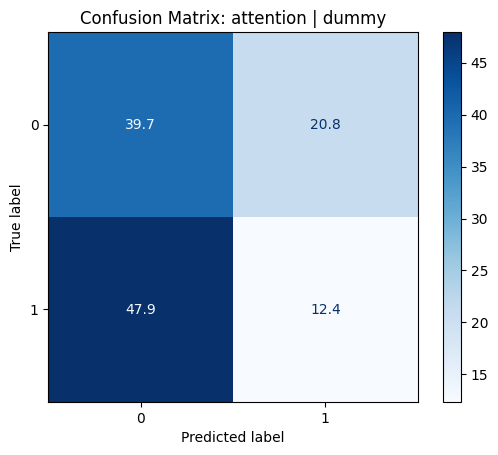

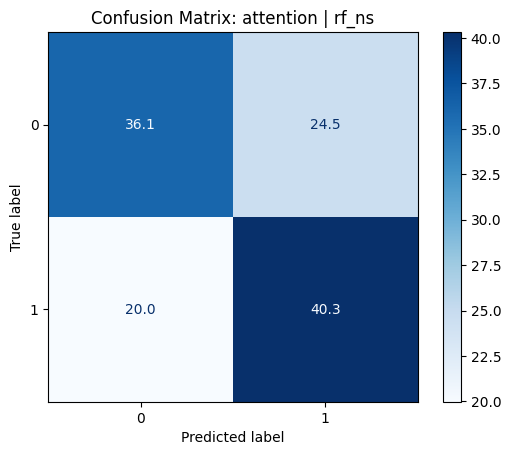

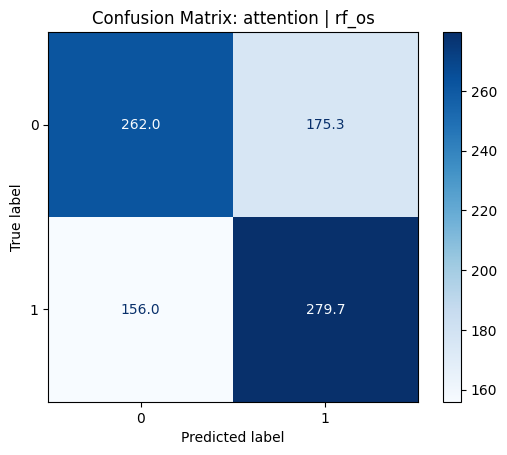

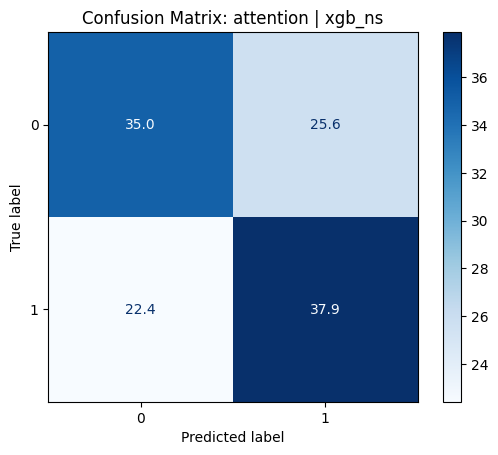

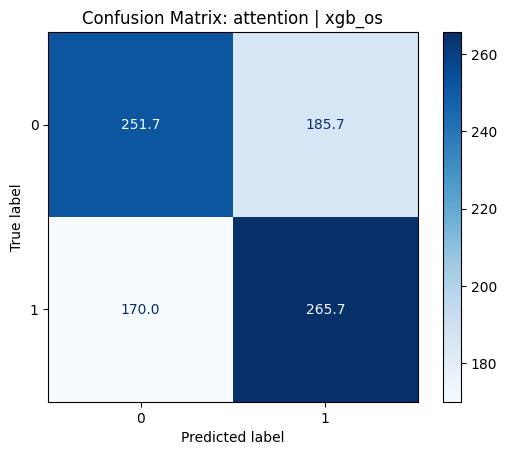

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

# 수치: split 별 예측한 class(0,1)의 평균 및 표준편차

# confusion matrix 관련 metric만 필터링
cm_metrics = ['true_0_pred_0', 'true_0_pred_1', 'true_1_pred_0', 'true_1_pred_1']
cm_data = SUMMARY_EVAL[SUMMARY_EVAL['metric'].isin([f'test_{m}' for m in cm_metrics])]

# label, alg 단위로 시각화
for (label, alg), group in cm_data.groupby(['label', 'alg']):
    try:
        cm = np.array([
            [
                group.loc[group['metric'] == 'test_true_0_pred_0', 'mean'].values[0],
                group.loc[group['metric'] == 'test_true_0_pred_1', 'mean'].values[0],
            ],
            [
                group.loc[group['metric'] == 'test_true_1_pred_0', 'mean'].values[0],
                group.loc[group['metric'] == 'test_true_1_pred_1', 'mean'].values[0],
            ]
        ])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(cmap='Blues', values_format='.1f')
        plt.title(f'Confusion Matrix: {label} | {alg}')
        plt.show()
    except Exception as e:
        print(f"[{label}, {alg}] error: {e}")

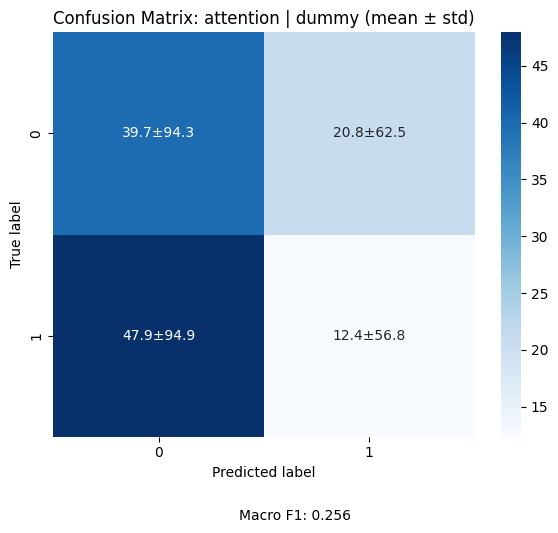

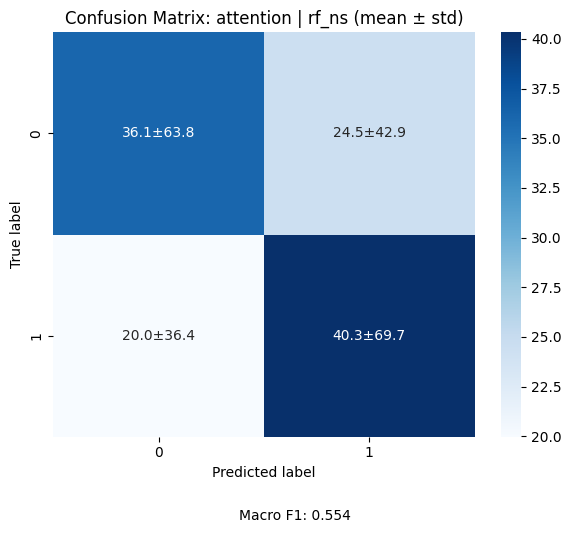

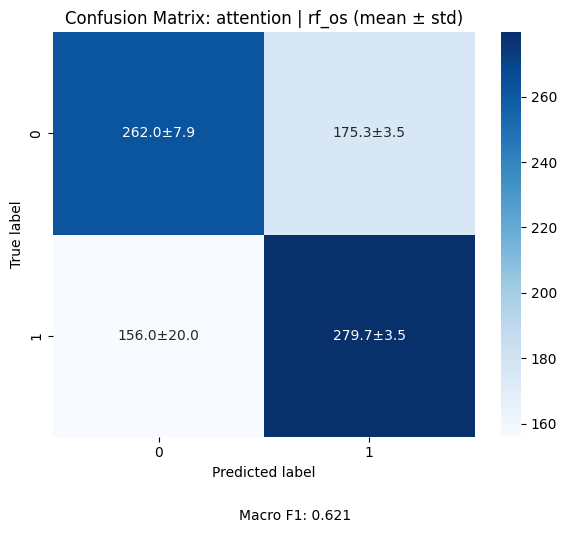

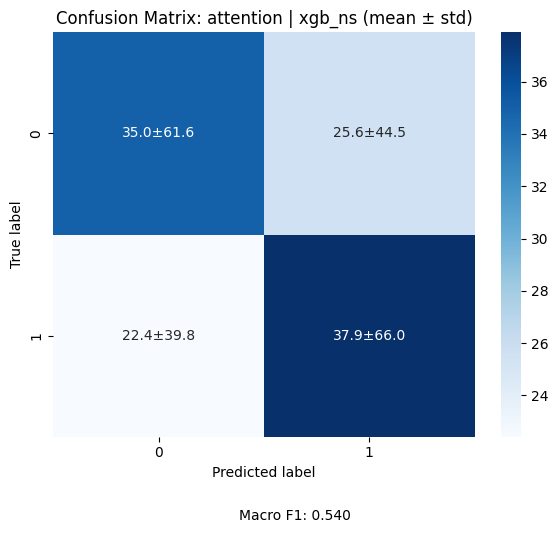

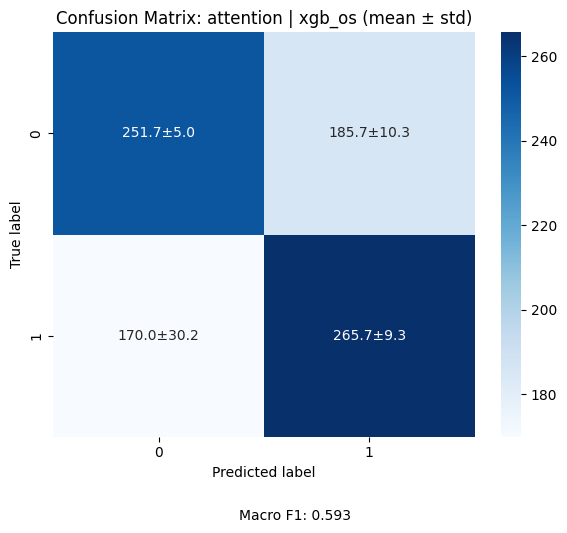

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# metric 분리
cm_metrics = ['true_0_pred_0', 'true_0_pred_1', 'true_1_pred_0', 'true_1_pred_1']
f1_metrics = ['f1_macro', 'f1_micro']
cm_metrics = [f'test_{m}' for m in cm_metrics]
f1_metrics = [f'test_{m}' for m in f1_metrics]

# pivot
mean_cm_df = SUMMARY_EVAL[SUMMARY_EVAL['metric'].isin(cm_metrics)].pivot(index=['label', 'alg'], columns='metric', values='mean')
std_cm_df = SUMMARY_EVAL[SUMMARY_EVAL['metric'].isin(cm_metrics)].pivot(index=['label', 'alg'], columns='metric', values='SD')
f1_df = SUMMARY_EVAL[SUMMARY_EVAL['metric'].isin(f1_metrics)].pivot(index=['label', 'alg'], columns='metric', values='mean')

# 시각화
for idx in mean_cm_df.index:
    try:
        mean_cm = np.array([
            [mean_cm_df.loc[idx, 'test_true_0_pred_0'], mean_cm_df.loc[idx, 'test_true_0_pred_1']],
            [mean_cm_df.loc[idx, 'test_true_1_pred_0'], mean_cm_df.loc[idx, 'test_true_1_pred_1']]
        ])
        std_cm = np.array([
            [std_cm_df.loc[idx, 'test_true_0_pred_0'], std_cm_df.loc[idx, 'test_true_0_pred_1']],
            [std_cm_df.loc[idx, 'test_true_1_pred_0'], std_cm_df.loc[idx, 'test_true_1_pred_1']]
        ])
        annotations = np.empty_like(mean_cm, dtype=object)
        for i in range(2):
            for j in range(2):
                annotations[i, j] = f"{mean_cm[i, j]:.1f}±{std_cm[i, j]:.1f}"

        # f1 score 값
        macro_f1 = f1_df.loc[idx, 'test_f1_macro']
        micro_f1 = f1_df.loc[idx, 'test_f1_micro'] if 'test_f1_micro' in f1_df.columns else None

        # 플롯
        plt.figure(figsize=(6, 5))
        sns.heatmap(mean_cm, annot=annotations, fmt='', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
        plt.title(f'Confusion Matrix: {idx[0]} | {idx[1]} (mean ± std)')
        plt.xlabel('Predicted label')
        plt.ylabel('True label')

        # 텍스트로 F1 표시
        f1_text = f"Macro F1: {macro_f1:.3f}"
        if micro_f1 is not None:
            f1_text += f" | Micro F1: {micro_f1:.3f}"
        plt.figtext(0.5, -0.05, f1_text, ha='center', fontsize=10)

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Skipping {idx} due to error: {e}")

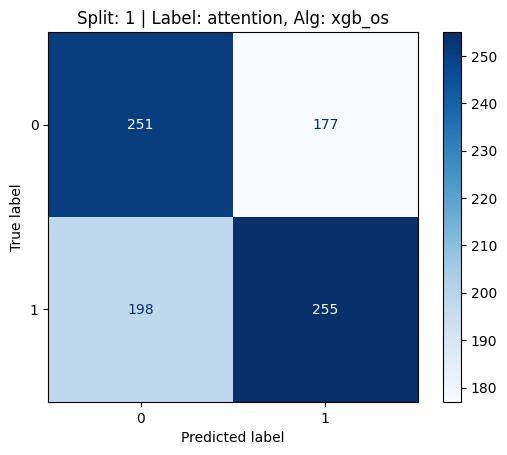

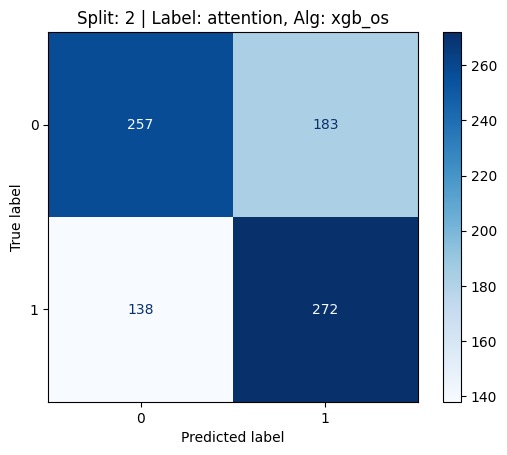

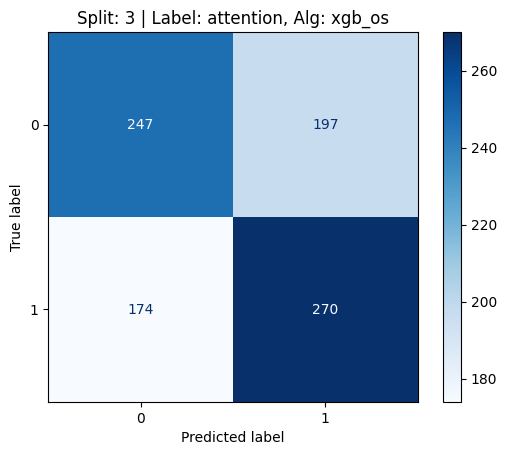

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_per_split(results_eval, label_filter=None, alg_filter=None):
    df = results_eval.copy()
    
    # 필터링
    if label_filter:
        df = df[df['label'] == label_filter]
    if alg_filter:
        df = df[df['alg'] == alg_filter]
    
    # split 단위로 출력
    for row in df.itertuples():
        cm = np.array([
            [getattr(row, 'test_true_0_pred_0'), getattr(row, 'test_true_0_pred_1')],
            [getattr(row, 'test_true_1_pred_0'), getattr(row, 'test_true_1_pred_1')]
        ])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(cmap='Blues', values_format='d')
        plt.title(f"Split: {row.split} | Label: {row.label}, Alg: {row.alg}")
        plt.show()
plot_confusion_per_split(RESULTS_EVAL, label_filter='attention', alg_filter='xgb_os')

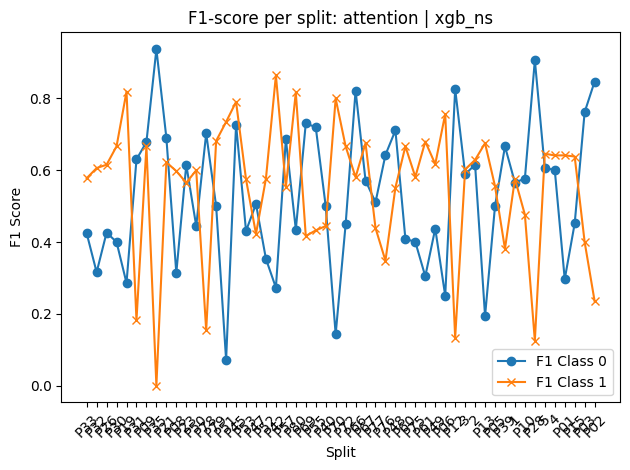

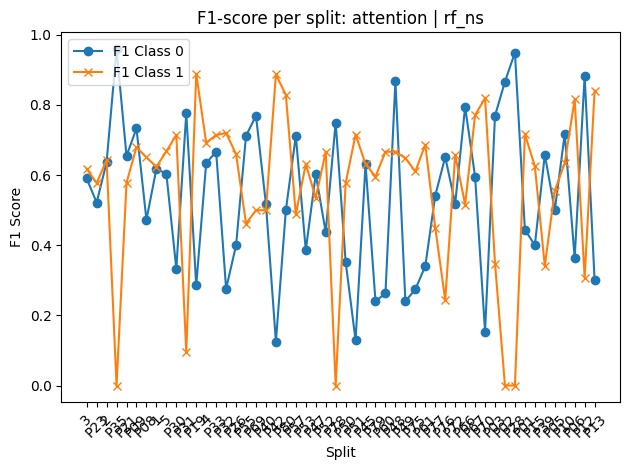

In [47]:
def plot_f1_per_split(results_eval, label, alg):
    df = results_eval[(results_eval['label'] == label) & (results_eval['alg'] == alg)]
    f1_0 = df['test_f1_0']
    f1_1 = df['test_f1_1']
    splits = df['split']

    plt.plot(splits, f1_0, label='F1 Class 0', marker='o')
    plt.plot(splits, f1_1, label='F1 Class 1', marker='x')
    plt.xticks(rotation=45)
    plt.xlabel('Split')
    plt.ylabel('F1 Score')
    plt.title(f'F1-score per split: {label} | {alg}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
plot_f1_per_split(RESULTS_EVAL, label='attention', alg='xgb_ns')
plot_f1_per_split(RESULTS_EVAL, label='attention', alg='rf_ns')


In [48]:
worst_splits = RESULTS_EVAL[
    (RESULTS_EVAL['label'] == 'attention') &
    (RESULTS_EVAL['alg'] == 'rf_ns') &
    (RESULTS_EVAL['test_inst_1'] < 100)
]
print(worst_splits[['split', 'test_inst_0', 'test_inst_1', 'test_f1_1']])

    split  test_inst_0  test_inst_1  test_f1_1
5     P23           26           23   0.576923
10    P35           49            2   0.000000
11    P21           29           21   0.577778
12    P09           28           27   0.680000
16    P08           26           43   0.650602
24    P30           27           43   0.714286
28    P31           41           12   0.095238
29    P19            7           45   0.888889
32    P33           17           22   0.714286
38    P32           18           34   0.720000
39    P26           34           42   0.659794
44    P55           36           20   0.461538
45    P69           50           26   0.500000
47    P40           29           28   0.500000
54    P42            6           64   0.887097
59    P80           14           33   0.828571
60    P57           35           22   0.487805
64    P53           37           39   0.631579
65    P47           40           37   0.535211
69    P52           16           27   0.666667
74    P78    

# Feature Importances

## Implementation

In [49]:
from typing import Union, Optional


def feature_importance(
    estimator
):
    if not hasattr(estimator, 'feature_names_in_') or not hasattr(estimator, 'feature_importances_'):
        return None
    
    names = estimator.feature_names_in_
    importances = estimator.feature_importances_
    
    return names, importances

## Execution

In [50]:
import os
import pandas as pd
from collections import defaultdict


IMPORTANCE_EVAL = defaultdict(list)
DIR_EVAL = os.path.join(PATH_INTERMEDIATE, 'eval')

for l in ['attention']:
    dir_l = os.path.join(DIR_EVAL, l)
    if not os.path.exists(dir_l):
        continue
    
    for f in os.listdir(dir_l):
        res = load(os.path.join(dir_l, f))

        f_norm = f[:f.index('.pkl')]
        alg = f_norm[:f.rindex('#')]
        
        feat_imp = feature_importance(res.estimator)
        if not feat_imp:
            continue
            
        names, importance = feat_imp
        new_names = []
        for n in names:
            for c in res.categories:
                n = n.replace(f'{c}_', f'{c}=')
            new_names.append(n)
        
        d = pd.DataFrame(
            importance.reshape(1, -1),
            columns=new_names
        )
        IMPORTANCE_EVAL[(l, alg)].append(d)
        

IMPORTANCE_SUMMARY = []

for (l, alg), v in IMPORTANCE_EVAL.items():
    new_v = pd.concat(
        v, axis=0
    ).fillna(0.0).mean().reset_index().set_axis(
        ['feature', 'importance'], axis=1
    ).assign(
        label=l,
        alg=alg
    )
    IMPORTANCE_SUMMARY.append(new_v)
    
IMPORTANCE_SUMMARY = pd.concat(IMPORTANCE_SUMMARY, axis=0, ignore_index=True)


### Plot